**Face Position Detection**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
driv_data = pd.read_csv('drivPoints.txt')
display(driv_data)

,fileName,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
0,20130529_01_Driv_001_f,1,1,2,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278
1,20130529_01_Driv_002_f,1,2,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281
2,20130529_01_Driv_003_f,1,3,2,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282
3,20130529_01_Driv_004_f,1,4,2,0,287,202,112,118,325,230,369,230,353,253,335,274,362,275
4,20130529_01_Driv_005_f,1,5,2,0,290,193,104,119,325,224,366,225,353,244,333,268,363,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,20130530_04_Driv_086_f,4,86,2,-15,278,183,128,141,307,218,354,210,330,247,324,273,356,266
602,20130530_04_Driv_087_lr,4,87,1,-30,268,186,128,134,296,222,344,212,319,247,316,274,347,269
603,20130530_04_Driv_088_lr,4,88,1,-30,264,187,127,131,287,220,334,211,304,247,305,272,337,270
604,20130530_04_Driv_089_f,4,89,2,-15,264,175,143,136,295,207,345,200,320,234,314,261,351,251


In [ ]:
print('Angles:', driv_data['ang'].unique())
print('Label:', driv_data['label'].unique())
print("/*************/")
display(driv_data.corr()['label'])

Angles: [  0 -15 -30 -45  15  30  45]
Label: [2 1 3]
/*************/


subject    0.031872
imgNum     0.050105
label      1.000000
ang        0.785522
xF         0.408662
yF        -0.049579
wF        -0.007389
hF         0.086531
xRE        0.533790
yRE       -0.058692
xLE        0.485336
yLE       -0.039557
xN         0.588441
yN        -0.061158
xRM        0.567880
yRM       -0.056930
xLM        0.491974
yLM       -0.037165
Name: label, dtype: float64

In [ ]:
features=['xF', 'xRE', 'xLE', 'xN', 'xRM', 'xLM']
driv_df = driv_data[features].copy()
driv_df['X0'] = 1
driv_df['label'] = driv_data['label'].copy()
display(driv_df)

,xF,xRE,xLE,xN,xRM,xLM,X0,label
0,292,323,367,353,332,361,1,2
1,286,324,366,353,333,361,1,2
2,290,325,367,351,334,362,1,2
3,287,325,369,353,335,362,1,2
4,290,325,366,353,333,363,1,2
...,...,...,...,...,...,...,...,...
601,278,307,354,330,324,356,1,2
602,268,296,344,319,316,347,1,1
603,264,287,334,304,305,337,1,1
604,264,295,345,320,314,351,1,2


In [ ]:
for i in range(3):
    print("No. of Samples of Label-{}: {}".format(i+1, len(driv_df[driv_df['label'] == i+1])))

No. of Samples of Label-1: 27
No. of Samples of Label-2: 546
No. of Samples of Label-3: 33


**Logistic** **Regression**


In [ ]:
def logLoss(predicted, train_Y):
    _train_Y = np.subtract(1, train_Y)
    _predicted = np.subtract(1, predicted)
    return -1 * np.nan_to_num(np.multiply(train_Y, np.log(predicted)) + np.multiply(_train_Y, np.log(_predicted))).mean()

def predict(weight, sample):
    return 1 / (1 + np.exp(-1 * np.sum(np.multiply(weight, sample))))


In [ ]:
def logistic_regression(train_X, train_Y, alpha, ro, epoch, graph=True):
    no_of_coeff = len(train_X[0])
    
    weight = np.zeros(no_of_coeff)
    predicted = np.zeros(len(train_Y))
    curr_loss = prev_loss = float("inf")
    loss = []
    ep = 0
    for _ in range(epoch):
        ep += 1
        for i in range(len(predicted)):
            # Calc h(X) for ith training sample
            predicted[i] = predict(weight, train_X[i])

            # Update all parameters w0, w1, w2,..., wn 
            for j in range(no_of_coeff):
                weight[j] -= alpha * (predicted[i] - train_Y[i]) * train_X[i, j]
            
        curr_loss = logLoss(predicted, train_Y)
        loss.append(curr_loss)
        if abs(curr_loss - prev_loss) < ro:
            break
        prev_loss = curr_loss
    if graph:
        print("\nNo. of Epoch:", ep)
        print("Loss:", curr_loss)
        plt.plot(np.arange(ep), loss)
        plt.show()
    return weight, curr_loss

In [ ]:
def createY(train_Y, label):
    arr = np.array(train_Y)
    for i in range(len(arr)):
        arr[i] = 1 if arr[i] == label else 0
    return arr

def train_model(train_X, train_Y, alpha, ro, epoch):
    train_Y1 = createY(train_Y, 1)
    train_Y2 = createY(train_Y, 2)
    train_Y3 = createY(train_Y, 3)

    weight0, mse = logistic_regression(train_X, train_Y1, alpha[0], ro, epoch[0])
    weight1, mse = logistic_regression(train_X, train_Y2, alpha[1], ro, epoch[1])
    weight2, mse = logistic_regression(train_X, train_Y3, alpha[2], ro, epoch[2])
    
    return np.array([weight0, weight1, weight2])

def predictClass(model, val_X):
    predicted = np.zeros(len(val_X), dtype=np.int8)
    for i in range(len(val_X)):
        prob = np.array([predict(weight, val_X[i]) for weight in model])
        predicted[i] = np.argmax(prob) + 1
    return predicted


In [ ]:
def accuracy(predicted, actual):
    return 1 - (np.count_nonzero(np.subtract(predicted, actual)) / len(actual))

def precision(predicted, actual, label):
    true = 0
    total = 0
    for i in range(len(predicted)):
        if predicted[i] == label and actual[i] == label:
            true += 1
        if predicted[i] == label:
            total += 1
    if total == 0:
        return 0
    else:
        return true/total

def recall(predicted, actual, label):
    true = 0
    total = 0
    for i in range(len(predicted)):
        if predicted[i] == label and actual[i] == label:
            true += 1
        if actual[i] == label:
            total += 1
    if total == 0:
        return 0
    else:
        return true/total

def printMetrics(model, data_X, actual):
    predicted = predictClass(model, data_X)

    print("\nOverAll Accuracy: {:.2%}".format(accuracy(predicted, actual)))
    for i in range(1, 4):
        print("Precision for class {}: {:.2%}".format(i, precision(predicted, actual, i)))
    print()
    for i in range(1, 4):
        print("Recall for class {}: {:.2%}".format(i, recall(predicted, actual, i)))
    print("\n",predicted)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

random_driv_df = driv_df.sample(frac=1)
driv_X = normalize(np.array(random_driv_df[features]))
driv_y = np.array(random_driv_df['label'])

train_X, val_X, test_X = np.split(driv_X, [int(.5*len(driv_X)), int(.75*len(driv_X))])
train_Y, val_Y, test_Y = np.split(driv_y, [int(.5*len(driv_y)), int(.75*len(driv_y))])

Label: 1


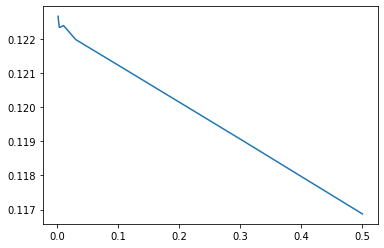

Label: 2


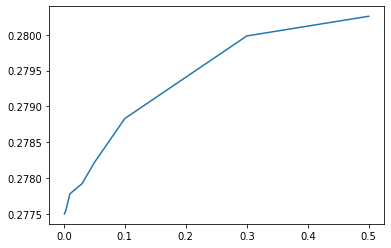

Label: 3


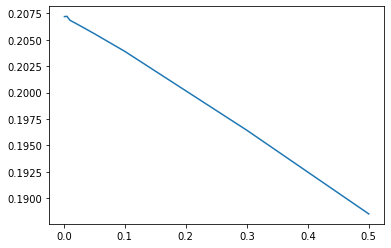

In [ ]:
def tuning(data_X, data_Y, alpha, ro, epoch, label):
    mse = []
    for a in alpha:
        weight, m = logistic_regression(val_X, createY(val_Y, label), a, ro, epoch, False)
        mse.append(m)
    plt.plot(alpha, mse)
    plt.show()

alpha_tune = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3,0.5]
ro = 1e-6
for i in range(3):
    print('Label: {}'.format(i+1))
    tuning(val_X, val_Y, alpha_tune, ro, 500, i+1)


No. of Epoch: 500
Loss: 0.16578911279648378


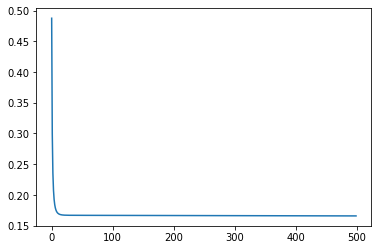


No. of Epoch: 500
Loss: 0.3286376386433972


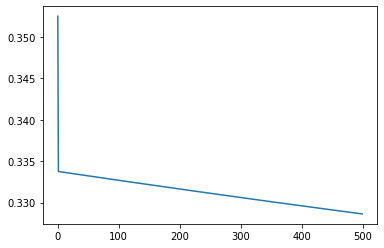


No. of Epoch: 500
Loss: 0.1861947448269283


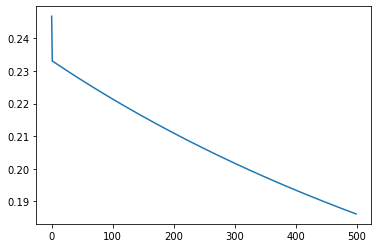

In [ ]:
alpha = np.array([0.01,0.3,0.5])
max_epoch = np.array([500, 500, 500])

model = train_model(train_X, train_Y, alpha, ro, max_epoch)

In [ ]:
print('Metrics for Training Samples:-')
printMetrics(model, train_X, np.array(train_Y))

Metrics for Training Samples:-

OverAll Accuracy: 89.77%
Precision for class 1: 0.00%
Precision for class 2: 89.77%
Precision for class 3: 0.00%

Recall for class 1: 0.00%
Recall for class 2: 100.00%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


In [ ]:
print('Metrics for Test Samples:-')
printMetrics(model, test_X, np.array(test_Y))

Metrics for Test Samples:-

OverAll Accuracy: 88.82%
Precision for class 1: 0.00%
Precision for class 2: 88.82%
Precision for class 3: 0.00%

Recall for class 1: 0.00%
Recall for class 2: 100.00%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [ ]:
printMetrics(model, np.array(driv_df[features]), np.array(driv_df['label']))
print("/***************?")
print(np.array(driv_df['label']))


OverAll Accuracy: 90.10%
Precision for class 1: 0.00%
Precision for class 2: 90.10%
Precision for class 3: 0.00%

Recall for class 1: 0.00%
Recall for class 2: 100.00%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


**K**-**Fold**(**Logistic** **Regression**)


Fold:  1

No. of Epoch: 500
Loss: 0.18705684679237825


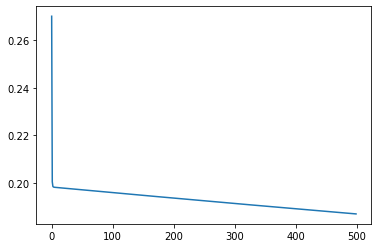


No. of Epoch: 500
Loss: 0.33462281189498433


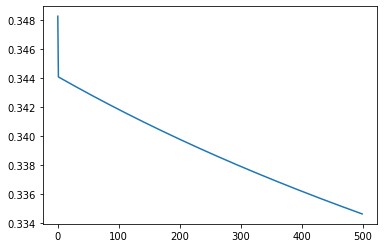


No. of Epoch: 500
Loss: 0.16198329277149126


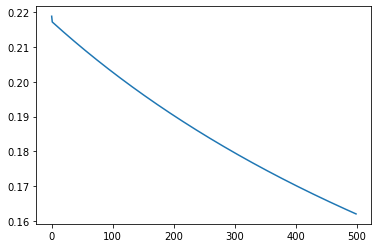


OverAll Accuracy: 92.62%

Precision for class 0: 0.00%
Precision for class 1: 92.62%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  2

No. of Epoch: 500
Loss: 0.17279369700890915


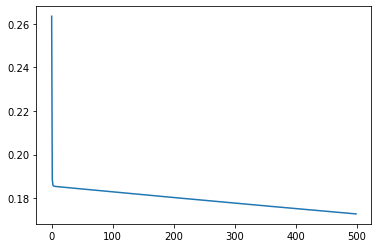


No. of Epoch: 500
Loss: 0.29381435458865324


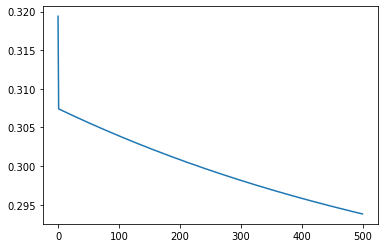


No. of Epoch: 500
Loss: 0.14726580470916345


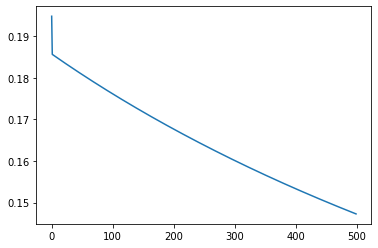


OverAll Accuracy: 85.95%

Precision for class 0: 0.00%
Precision for class 1: 85.95%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  3

No. of Epoch: 500
Loss: 0.16730998214487422


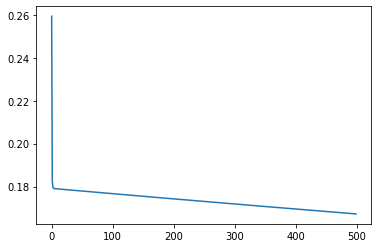


No. of Epoch: 500
Loss: 0.3400331083048721


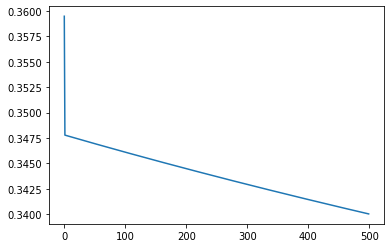


No. of Epoch: 500
Loss: 0.1701164784074846


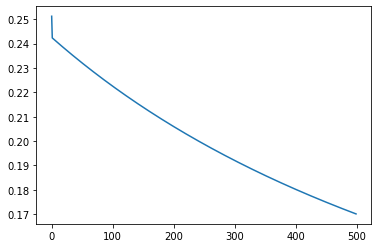


OverAll Accuracy: 93.39%

Precision for class 0: 0.00%
Precision for class 1: 93.39%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  4

No. of Epoch: 500
Loss: 0.1745891489546883


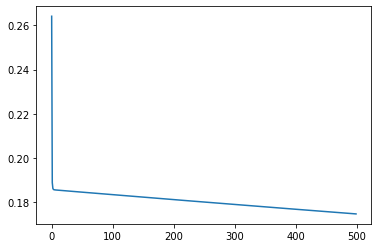


No. of Epoch: 500
Loss: 0.3134080909355028


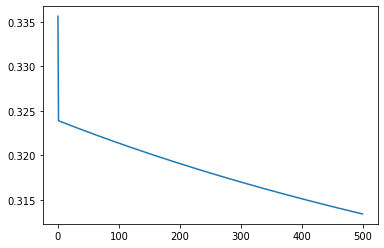


No. of Epoch: 500
Loss: 0.15810597923010739


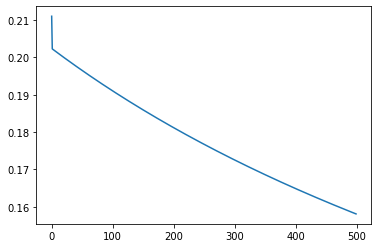


OverAll Accuracy: 89.26%

Precision for class 0: 0.00%
Precision for class 1: 89.26%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  5

No. of Epoch: 500
Loss: 0.15826880359457543


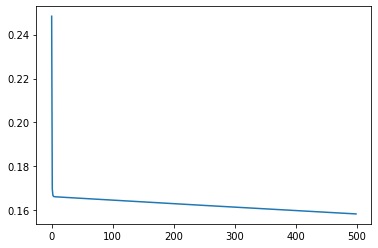


No. of Epoch: 500
Loss: 0.3161693364357284


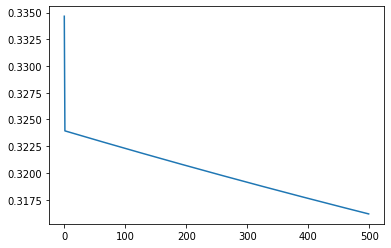


No. of Epoch: 500
Loss: 0.16215321152675016


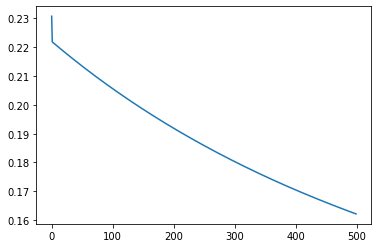


OverAll Accuracy: 89.26%

Precision for class 0: 0.00%
Precision for class 1: 89.26%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%



In [ ]:
from sklearn.model_selection import KFold
alpha = np.array([0.05, 0.3, 0.5])
max_epoch = np.array([500, 500, 500])
ro = 1e-6

kf = KFold(n_splits=5)

precision_arr = np.zeros(3)
recall_arr = np.zeros(3)

fold = 0
for train_index, test_index in kf.split(driv_X):
    fold += 1
    print("Fold: ", fold)
    
    X_train, X_test = driv_X[train_index], driv_X[test_index]
    y_train, y_test = driv_y[train_index], driv_y[test_index]

    model = train_model(X_train, y_train, alpha, ro, max_epoch)
    y_predicted = predictClass(model, X_test)
    print("\nOverAll Accuracy: {:.2%}".format(accuracy(y_predicted, y_test)))

    print()
    for i in range(3):
        x = precision(y_predicted, y_test, i+1)
        precision_arr[i] += x
        print("Precision for class {}: {:.2%}".format(i, x))

    print()
    for i in range(3):
        x = recall(y_predicted, y_test, i+1)
        recall_arr[i] += x
        print("Recall for class {}: {:.2%}".format(i, x))
    print()


In [ ]:
for i in range(3):
    print("Average Precision of Class {}: {:.2%}".format(i+1, precision_arr[i] / 5))

print()
for i in range(3):
    print("Average Recall of Class {}: {:.2%}".format(i+1, recall_arr[i] / 5))

Average Precision of Class 1: 0.00%
Average Precision of Class 2: 90.09%
Average Precision of Class 3: 0.00%

Average Recall of Class 1: 0.00%
Average Recall of Class 2: 100.00%
Average Recall of Class 3: 0.00%


**Sigmoid** **neuron**

In [ ]:
def converge(train_X, train_Y, weight):
    for i in range(len(train_X)):
        hX = np.sum(np.multiply(train_X[i], weight))
        if train_Y[i] == 1 and hX < 0:
            return False
        elif train_Y[i] == 0 and hX >= 0:
            return False
    return True

In [ ]:
def sigmoid_neuron(train_X, train_Y, max_epoch):
    length = len(train_X)
    deg = len(train_X[0])
    weight = np.array([0.3]*deg, dtype=np.float128)
    epoch = 0
    while not(converge(train_X, train_Y, weight)) and epoch <= max_epoch:
        epoch += 1
        enum = np.arange(length)
        np.random.shuffle(enum)
        for i in enum:
            hX = predict(weight, train_X[i]) 
            if train_Y[i] == 1 and hX < 0.5:
                weight += train_X[i]
            elif train_Y[i] == 0 and hX >= 0.5:
                weight -= train_X[i]
        # print(weight)
    return weight

In [ ]:
def train_neuron(train_X, train_Y, epoch):
    train_Y0 = createY(train_Y, 1)
    train_Y1 = createY(train_Y, 2)
    train_Y2 = createY(train_Y, 3)

    weight0 = sigmoid_neuron(train_X, train_Y0, epoch[0])
    weight1 = sigmoid_neuron(train_X, train_Y1, epoch[1])
    weight2 = sigmoid_neuron(train_X, train_Y2, epoch[2])
    
    return np.array([weight0, weight1, weight2])

In [ ]:
train_X, test_X = np.split(driv_X, [int(.5*len(driv_X))])
train_Y, test_Y = np.split(driv_y, [int(.5*len(driv_y))])
max_epoch = [500, 500, 500]
model_p = train_neuron(train_X, train_Y, max_epoch)

In [ ]:
print('Metrics for Training Samples:-')
printMetrics(model_p, train_X, train_Y)

Metrics for Training Samples:-

OverAll Accuracy: 90.10%
Precision for class 1: 100.00%
Precision for class 2: 90.07%
Precision for class 3: 0.00%

Recall for class 1: 8.33%
Recall for class 2: 100.00%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


In [ ]:
print('Metrics for Test Samples:-')
printMetrics(model_p, test_X, test_Y)

Metrics for Test Samples:-

OverAll Accuracy: 91.09%
Precision for class 1: 100.00%
Precision for class 2: 91.03%
Precision for class 3: 0.00%

Recall for class 1: 13.33%
Recall for class 2: 100.00%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


In [ ]:
printMetrics(model_p, np.array(driv_df[features]), np.array(driv_df['label']))


OverAll Accuracy: 92.90%
Precision for class 1: 94.74%
Precision for class 2: 92.84%
Precision for class 3: 0.00%

Recall for class 1: 66.67%
Recall for class 2: 99.82%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2

Single Layer Perceptron


In [ ]:
def oneHotEncoding(df, label_name, label, target):
    for i in range(len(label)):
        df[label_name[i]] = pd.Series(createY(df[target], label[i]))

In [ ]:
def SLP(train_X, train_Y, alpha, ro, max_epoch):
    length = len(train_X)
    deg = len(train_X[0])
    no_of_class = len(train_Y[0])

    weight = np.zeros((no_of_class, deg))
    curr_loss = prev_loss = float("inf")
    hX = np.zeros(no_of_class)
    loss = []
    epoch = 0
    for _ in range(max_epoch):
        epoch += 1
        enum = np.arange(length)
        np.random.shuffle(enum)
        curr_loss = 0
        for i in enum:
            # predict values
            for j in range(no_of_class):
                hX[j] = predict(weight[j], train_X[i])
            # error calc
            curr_loss += np.sum(np.square(hX - train_Y[i])) / 2
            
            # weight updation
            for j in range(no_of_class):
                for k in range(deg):
                    weight[j][k] += alpha * (train_Y[i][j] - hX[j]) * train_X[i][k] * hX[j] * (1 - hX[j])

        loss.append(curr_loss)
        if abs(curr_loss - prev_loss) < ro:
            break
        prev_loss = curr_loss
    print("No. of Epoch:", epoch, "\tLoss:", curr_loss)
    plt.plot(np.arange(epoch), loss)
    plt.show()
    return weight

In [ ]:
label_name = ['Y1', 'Y2', 'Y3']
label_value = [1, 2, 3]

In [ ]:
slp_driv_df = random_driv_df.copy()
oneHotEncoding(slp_driv_df, label_name, label_value, 'label')

slp_driv_X = normalize(np.array(slp_driv_df[features]))
slp_driv_Y = np.array(slp_driv_df[label_name])
slp_driv_label = np.array(slp_driv_df['label'])

train_X, test_X = np.split(slp_driv_X, [int(.5*len(slp_driv_X))])
train_Y, test_Y = np.split(slp_driv_Y, [int(.5*len(slp_driv_Y))])
train_label, test_label = np.split(slp_driv_label, [int(.5*len(slp_driv_label))])

No. of Epoch: 243 	Loss: 30.299422950750046


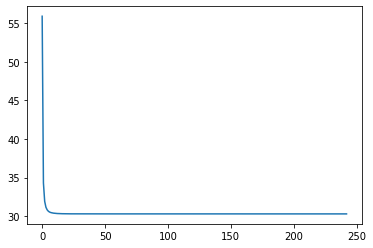

In [ ]:
alpha = 0.1
ro = 1e-6
max_epoch = 1000

model_s = SLP(train_X, train_Y, alpha, ro, max_epoch)

In [ ]:
printMetrics(model_s, test_X, test_label)


OverAll Accuracy: 90.43%
Precision for class 1: 0.00%
Precision for class 2: 90.43%
Precision for class 3: 0.00%

Recall for class 1: 0.00%
Recall for class 2: 100.00%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


In [ ]:
printMetrics(model_s, np.array(driv_df[features]), np.array(driv_df['label']))


OverAll Accuracy: 90.10%
Precision for class 1: 0.00%
Precision for class 2: 90.10%
Precision for class 3: 0.00%

Recall for class 1: 0.00%
Recall for class 2: 100.00%
Recall for class 3: 0.00%

 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


SLP K-Fold

Fold:  1
No. of Epoch: 146 	Loss: 38.32186953169349


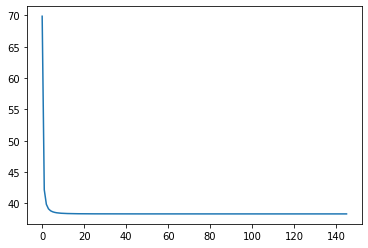


OverAll Accuracy: 92.62%

Precision for class 0: 0.00%
Precision for class 1: 92.62%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  2
No. of Epoch: 1000 	Loss: 46.947115062637266


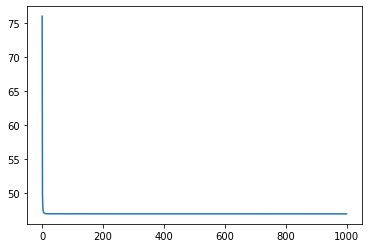


OverAll Accuracy: 85.95%

Precision for class 0: 0.00%
Precision for class 1: 85.95%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  3
No. of Epoch: 73 	Loss: 41.88565766933772


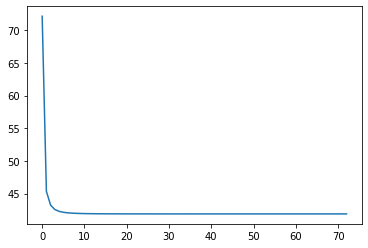


OverAll Accuracy: 93.39%

Precision for class 0: 0.00%
Precision for class 1: 93.39%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  4
No. of Epoch: 1000 	Loss: 48.66540798347442


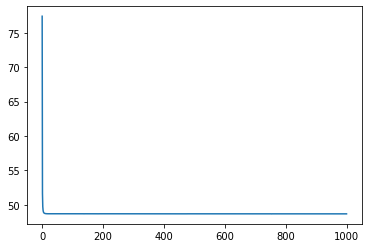


OverAll Accuracy: 89.26%

Precision for class 0: 0.00%
Precision for class 1: 89.26%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%

Fold:  5
No. of Epoch: 1000 	Loss: 46.149841267510254


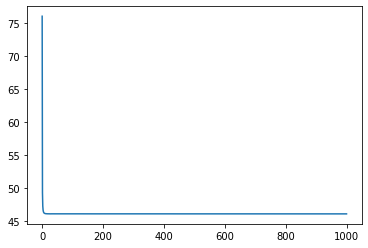


OverAll Accuracy: 89.26%

Precision for class 0: 0.00%
Precision for class 1: 89.26%
Precision for class 2: 0.00%

Recall for class 0: 0.00%
Recall for class 1: 100.00%
Recall for class 2: 0.00%



In [ ]:
kf = KFold(n_splits=5)

alpha = 0.1
ro = 1e-6
max_epoch = 1000


precision_arr = np.zeros(3)
recall_arr = np.zeros(3)

fold = 0
for train_index, test_index in kf.split(slp_driv_X):
    fold += 1
    print("Fold: ", fold)
    
    X_train, X_test = slp_driv_X[train_index], slp_driv_X[test_index]
    y_train, y_test = slp_driv_Y[train_index], slp_driv_Y[test_index]
    label_train, label_test = slp_driv_label[train_index], slp_driv_label[test_index]

    model = SLP(X_train, y_train, alpha, ro, max_epoch)
    y_predicted = predictClass(model, X_test)
    print("\nOverAll Accuracy: {:.2%}".format(accuracy(y_predicted, label_test)))

    print()
    for i in range(3):
        x = precision(y_predicted, label_test, i+1)
        precision_arr[i] += x
        print("Precision for class {}: {:.2%}".format(i, x))

    print()
    for i in range(3):
        x = recall(y_predicted, label_test, i+1)
        recall_arr[i] += x
        print("Recall for class {}: {:.2%}".format(i, x))
    print()

In [ ]:
for i in range(3):
    print("Average Precision of Class {}: {:.2%}".format(i+1, precision_arr[i] / 5))

print()
for i in range(3):
    print("Average Recall of Class {}: {:.2%}".format(i+1, recall_arr[i] / 5))

Average Precision of Class 1: 0.00%
Average Precision of Class 2: 90.09%
Average Precision of Class 3: 0.00%

Average Recall of Class 1: 0.00%
Average Recall of Class 2: 100.00%
Average Recall of Class 3: 0.00%
